In [1]:
from functools import partial
import jax
from jax import grad, jit, lax, random, vmap
import jax.numpy as jnp
import jax.scipy as scipy
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["font.size"] = 24

Another way to inform model fitting is through maximum likelihood methods. Instead of minimizing error, we incorporate a probability model for how we expect our data to be generated given the model and its parameters.

This is the concept of likelihood. The likelihood of data $Y$ given a model $m$ and parameters $\theta$ is 

$$
L(\theta \mid Y) = \text{Prob}[ Y = G(m, \theta)],
$$

for some function $G$ of the model and its parameters. Functionally, this likelihood will replace the losses we used in the previous notebook as maximizing this likelihood corresponds to finding the parameter set $\theta^{*}$ which is most likely to have produced the data.

$$
\theta^{*} = \text{arg max}_{\theta} \Big[ L(\theta \mid Y)\Big]
$$

Oftentimes for computational ease, we'll instead minimize the negative loglikelihood, so our problem becomes

$$
\theta^{*} = \text{arg min}_{\theta} \Big[ - \log L(\theta \mid Y) \Big].
$$

This is indeed more helpful for dealing with multiple observation because assuming independence, we have

$$
L(\theta \mid Y_{1}, Y_{2}, \ldots, Y_{N} ) = \prod_{i=1}^{N} L(\theta \mid Y_{i})
$$

which turns into 

$$
-\log L(\theta \mid Y_{1}, \ldots, Y_{N}) = - \sum_{i=1}^{N} \log L(\theta \mid Y_{i}).
$$

This is extremely helpful especially when your model has some stochastic component either at obersvation or in the process being modeled.

## Example: Least squares (again)

To keep things simple, we'll start with the example of linear regression again. In this case, we can rewrite our model as

\begin{align}
y &= \beta_{0} + \beta_{1} x + \epsilon\\
\epsilon &\sim \text{Normal}(0, \sigma)
\end{align}

Alternatively, we can write this as

$$
Y \sim \text{Normal}(\beta_{0} + \beta_{1} x, \sigma).
$$


In [3]:
# We can instead use built-in optimizers to 
# Maximize the likelihood assuming normal errors

In [4]:
## Simulating linear regression data
def linear_expectation(X, β):
    return jnp.dot(X, β)

def simulate_linear_data(X, β, σ, key = None):
    if key is None:
        key = random.PRNGKey(SEED)
        
    key, subkey = random.split(key)
    EY = jnp.dot(X, β)
    return EY + σ * random.normal(subkey, EY.shape)

SEED = 11 * 2 * 2021
key = random.PRNGKey(SEED)
key, subkey = random.split(key)

X = jnp.stack([jnp.repeat(1, 100), 
               jnp.array([t for t in range(100)])]).T # Feature matrix
β = jnp.array([2.0, 0.1]) # True parameters
σ = 1.0 # Noise level

Y = simulate_linear_data(X, β, σ, key = key) # Simulated data

Text(0, 0.5, 'Brownies consumed')

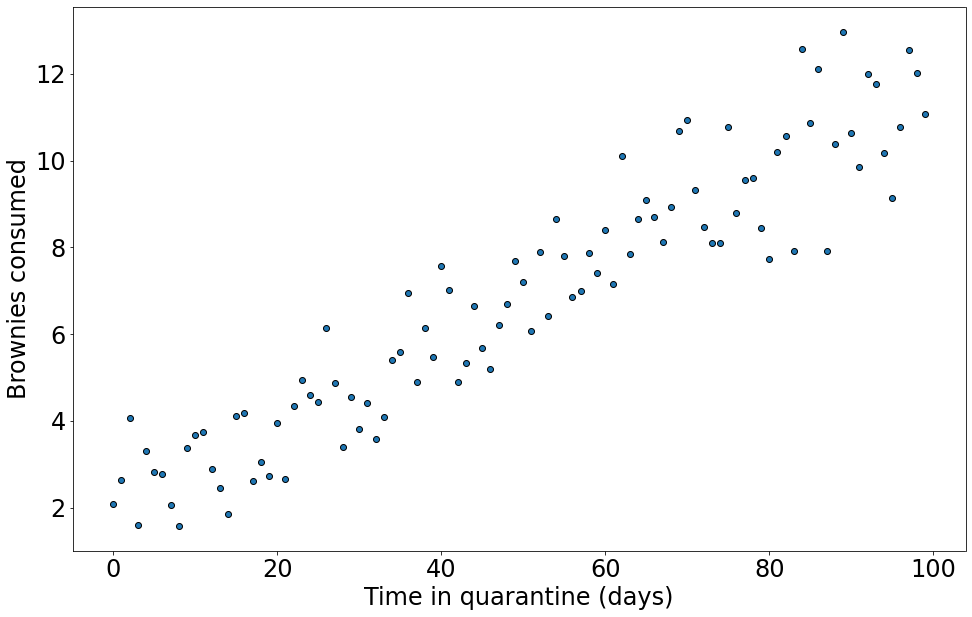

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:,1], Y, 
           edgecolors='k') # Plotting X in time 
ax.set_xlabel("Time in quarantine (days)")
ax.set_ylabel("Brownies consumed")

We can fit our model using built-in minimize methods in jax and scipy, but first we must define the likelihood. Notice, that as before, we will transform parameters from the unconstrained space to the constrained space. In this example, we use $\ln \sigma \in (-\infty, \infty)$ as opposed to $\sigma > 0$.

In [6]:
def loglik(β, σ, X, Y):
   # Z = (Y - jnp.dot(X,β))/σ
    return jnp.sum(scipy.stats.norm.logpdf(Y, 
                                           loc=jnp.dot(X,β),
                                           scale=σ))

In [7]:
from jax.scipy.optimize import minimize

obj = lambda θ : -loglik(θ[0:2], jnp.exp(θ[2]), X, Y)
θ0 = jnp.array([0.01, 0.01, 1.])
opt = minimize(obj, θ0, method = "BFGS") 

# Transform parameters back
β_hat = opt.x[0:2]
σ_hat = jnp.exp(opt.x[2])

In [8]:
β_hat

DeviceArray([1.953459  , 0.09804668], dtype=float32)

In [9]:
σ_hat

DeviceArray(1.0322869, dtype=float32)

Text(0, 0.5, 'Brownies consumed')

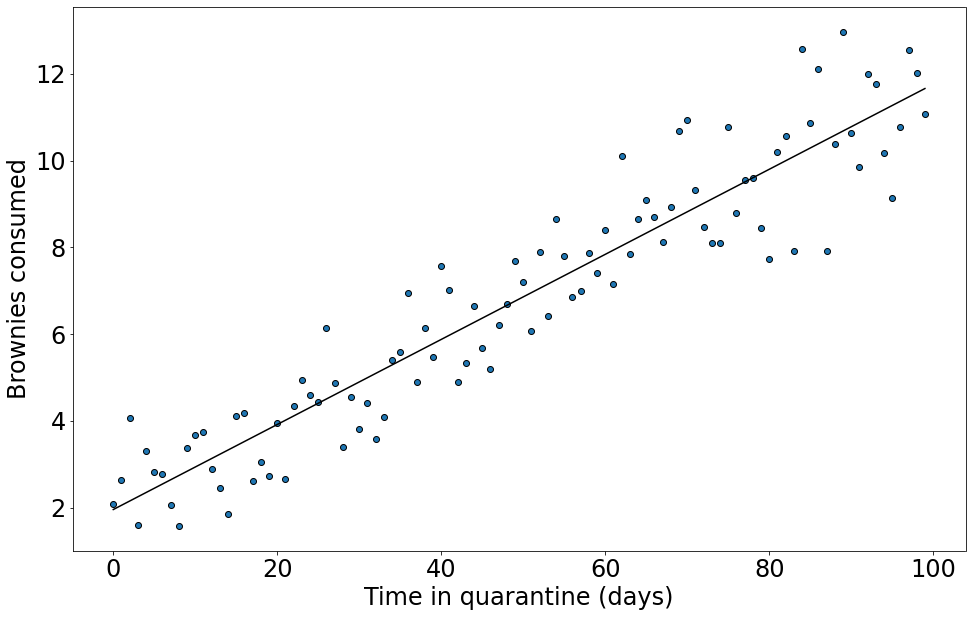

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X[:,1], Y, 
           edgecolors='k') # Plotting X in time 

ax.plot(X[:,1], jnp.dot(X, β_hat), color = "black")
ax.set_xlabel("Time in quarantine (days)")
ax.set_ylabel("Brownies consumed")

Notice this is basically the same solution as with the other methods. We can see this analytically by noting that for $f(y)$ with density  $\text{Normal}(X \beta, \sigma)$

\begin{align}
-\log L(Y \mid \beta) &= -\log f(Y)\\
                  &\approx \frac{1}{\sigma^2}(Y - X\beta)^2 +\frac{1}{2}\log \sigma.
\end{align}

The optimal $\beta$ are then those which minimize the mean squared error. As an exercise, you can determine what the corresponding $\sigma$ must be when the least squared error is minimized.


Though on its own, this isn't the most helpful. Let's visualize the likelihood and where different points fall on it.


In [11]:
def simulate_near(β, noise, N, key=None):
    if key is None:
        key = random.PRNGKey(SEED)   
    
    key, subkey = random.split(key)
    return β + noise * random.normal(subkey, (N, β.shape[-1]))

plot_obj = lambda β : loglik(β, σ_hat, X, Y)
β_near = simulate_near(β, jnp.array([2.,0.05]), 400)

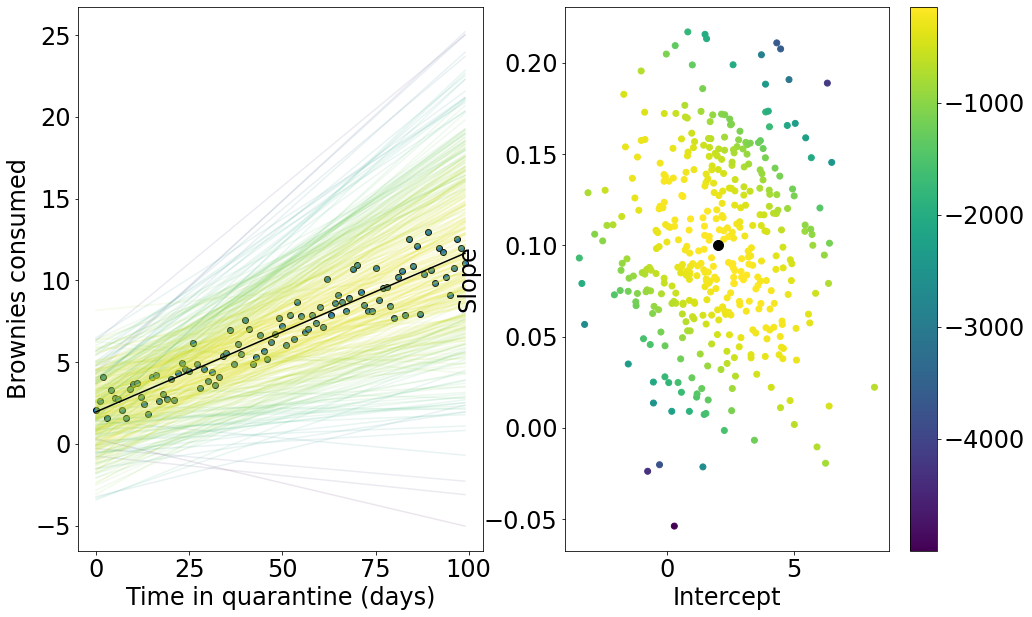

In [12]:
from matplotlib import cm
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

this_cmap = 'viridis'



normed_c = 1 - vmap(plot_obj)(β_near) / vmap(plot_obj)(β_near).min()

for i in range(β_near.shape[0]):
    ax1.plot(X[:,1], jnp.dot(X, β_near[i, :]), 
             c=cm.viridis(normed_c[i]), alpha = 0.1)
    
ax1.scatter(X[:,1], Y, 
           edgecolors='k') # Plotting X in time 
ax1.plot(X[:,1], jnp.dot(X, β_hat), color = "black")
ax1.set_xlabel("Time in quarantine (days)")
ax1.set_ylabel("Brownies consumed")

scd = ax2.scatter(β_near[:,0], β_near[:,1], 
           c = vmap(plot_obj)(β_near), 
           cmap = this_cmap)
ax2.scatter(β[0], β[1], s = 100, color = "black")
ax2.set_xlabel("Intercept")
ax2.set_ylabel("Slope")
fig.colorbar(scd)

## Example: Indirect observation

The maximum likelihood method is extremely powerful as it allows you to relate observation error to a probability model that you fit to your data. It also allows for more complex observation models than just MSE alone.


For example, let's assume that instead of actually observing animals directly in our Lotka-Volterra model before, we only had knowledge of the number of pelts produced from each animal. "

## Example: Stochastic models

These likelihood based models are also extremely applicable to stochastic models where latent states have their own associated probability distributions. For Markovian models, you can use methods like particle filtering or sequential monte carlo. A good resource for this kind of modeling is [POMP](https://kingaa.github.io/pomp/) which is a package in R for stochastic dynamic models.

I'm not going to do much in this direction.

## References

Theres's shockingly little material dedicated to maximum likelihood methods on their own.

### Blog posts

[Maximum Likelihood Estimation (Generic models) — statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/generic_mle.html)

https://analyticsindiamag.com/maximum-likelihood-estimation-python-guide/

https://towardsdatascience.com/a-gentle-introduction-to-maximum-likelihood-estimation-9fbff27ea12f

### Software

[POMP user guides and tutorials](https://kingaa.github.io/pomp/docs.html)